# Data quality

## How many property listings are there?

In [2]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_color_codes('pastel')

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [27]:
listings = pd.read_csv('../data/listings.csv')

In [34]:
def convert_pub_date(listings):
    '''
    Convert publication date to daytime. Listings posted on day scraper
    ran display time of posting - i.e. "8:35 am" - instead of the date ~
    24/12/2011. These must be transformed.
    '''
    # Get datetime of when the scraper ran.
    listings_no_today = listings[~listings.pub_date.str.contains('am')]
    today = pd.to_datetime(listings_no_today.pub_date).max()
    # Set strings with format '8:35 am' to scraper run date.
    has_am = listings.pub_date.str.contains('am')
    listings.loc[has_am, 'pub_date'] = today
    # Convert all publication dates to to datetime.
    listings.loc[:,'pub_date'] = pd.to_datetime(listings['pub_date'])
    return listings

In [35]:
## Convert publication date to datetime
listings = convert_pub_date(listings)

In [4]:
# Coerce price strings to floats.
listings.price_num = listings.price.str.replace(',','').astype(float)

In [5]:
# For some weird reason notes and other info fields aren't strings, coerce.
# @TODO: this coerces NaN's into 'nan'?!??!
listings.notes_str = listings.notes.astype(str)
listings.other_info_str = listings.other_info.astype(str)

In [4]:
num_listings = listings.shape[0]
num_listings

63863

Looks like just under 64 thousand.

## What are the columns?

In [5]:
listings.columns

Index(['azotea compartida', 'balcon', 'modified', 'corriente 220V',
       'sala-comedor', 'other_info', 'cocina', 'piscina', 'location',
       'agua las 24 horas', 'near_to', 'garaje', 'gas de balon',
       'independiente', 'patio', 'contact_name', 'tanque instalado', 'bajos',
       'telefono', 'placa libre', 'posibilidad de garaje', 'pasillo',
       'corriente 110V', 'interior', 'meters_squared', 'puntal alto',
       'num_bed', 'elevador', 'construction_era', 'num_bath', 'id',
       'azotea libre', 'terraza', 'mobile_number', 'price', 'patinejo',
       'puerta calle', 'pub_date', 'phone_number', 'portal', 'gas de la calle',
       'cocina-comedor', 'hall', 'altos', 'property_type', 'saleta', 'comedor',
       'barbacoa', 'jardin', 'notes', 'carposhe', 'sala', 'mod_date'],
      dtype='object')

## What percentage of each columns is not null?

In [6]:
pct_not_null = ((listings.count() / num_listings) * 100).sort_values()
pct_not_null

near_to                    2.502231
construction_era           5.231511
mod_date                   5.707530
meters_squared            15.086983
other_info                20.287177
mobile_number             41.221051
phone_number              76.026807
price                     79.213316
contact_name              85.645836
location                  99.276576
notes                     99.428464
id                       100.000000
azotea libre             100.000000
terraza                  100.000000
patinejo                 100.000000
puerta calle             100.000000
pub_date                 100.000000
jardin                   100.000000
num_bath                 100.000000
cocina-comedor           100.000000
hall                     100.000000
altos                    100.000000
carposhe                 100.000000
property_type            100.000000
saleta                   100.000000
comedor                  100.000000
barbacoa                 100.000000
portal                   100

We have price ~80% of the time, which is pretty good.

We have property type, number of beds, and numbers of baths 100% of the time, which is great. Accuracy, of course, is another issue.

We only have meters squared 15% of the time, and construction era, which is a proxy for construction quality, 5%. The size and quality of properties are key drivers of their price, so this will affect our ability to model prices.

85% of listings have contact names, and 76% have phone numbers, which might help us filter out the serious listings from the noise.

Only 5% of listings are ever modified.

To see what percentage of listings have actually have content of notes and other fields, further analysis is needed, because of the way I wrote the scraper, I think.

Location fields have to be cleaned up. Most only list the region.

## What can we learn about the completeness of the data from the auto-incrementing listings ids?

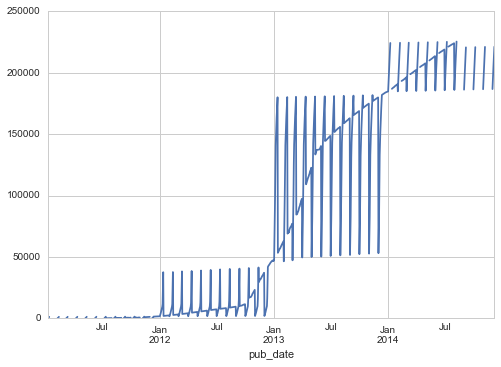

In [40]:
listings.set_index(listings.pub_date).sort_values()['id'].resample('D', how='median').plot()

Something very strange going on here..

- id's mostly increment one by one, but there are lots of gaps, either because people made but never published listings, published and immediately removed listings, or published and eventually deleted listings. That means we're missing observations. ids are up to ~230K, but but we only have ~63K listings, meaning we only have ~27% of listings that ever were assigned an id. If listings are taken down at random, this might not be a problem.

# What percentage of amenities columns are not null?
All amenities features are either True or False, so none are null. However, many listings appear to list no amenities whatsoever. We have to see how prevalent this is:

In [7]:
amenities = ['azotea libre', 'terraza', 'patinejo', 'puerta calle',
             'jardin', 'cocina-comedor', 'hall', 'altos',
             'carposhe', 'saleta', 'comedor', 'barbacoa',
             'portal', 'gas de la calle', 'azotea compartida', 'sala', 'balcon',
             'corriente 220V', 'sala-comedor', 'cocina', 'piscina',
             'agua las 24 horas', 'garaje', 'gas de balon', 'elevador',
             'independiente', 'tanque instalado', 'bajos', 'telefono',
             'placa libre', 'posibilidad de garaje', 'pasillo', 'corriente 110V',
             'interior', 'puntal alto', 'patio']

listing_amenities = listings[amenities]

In [8]:
num_amenities_per_listing = listing_amenities.sum(axis=1)
amenity_counts = num_amenities_per_listing.value_counts().sort_index()

In [9]:
num_listings_no_amenities = amenity_counts.loc[0]
pct_listings_no_amenities = (num_listings_no_amenities / num_listings) * 100
pct_listings_any_amenities = 100 - pct_listings_no_amenities
pct_listings_any_amenities

95.233546811142602

95% of listings feature at least one amenity.

## Does the distribution of amenities per listing look reasonable? Or does it point to data collection problems?

In [10]:
num_amenities_per_listing.describe()

count    63863.000000
mean         8.070056
std          4.716840
min          0.000000
25%          5.000000
50%          7.000000
75%         11.000000
max         36.000000
dtype: float64

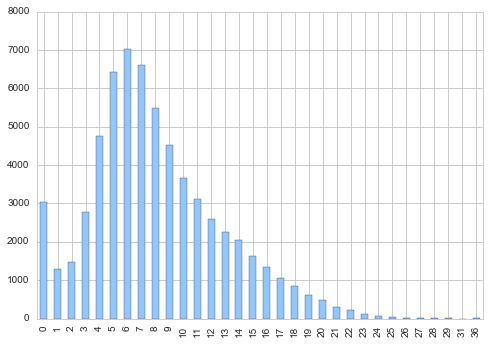

In [11]:
amenity_counts.plot(kind='bar')

Listings that have list amenities seem to follow a nice distribution, with a mean number of 8 amenities per listing. This boosts our confidence that the amenities data, although self-reported, is relatively accurate.

## What are the most popular amenities?

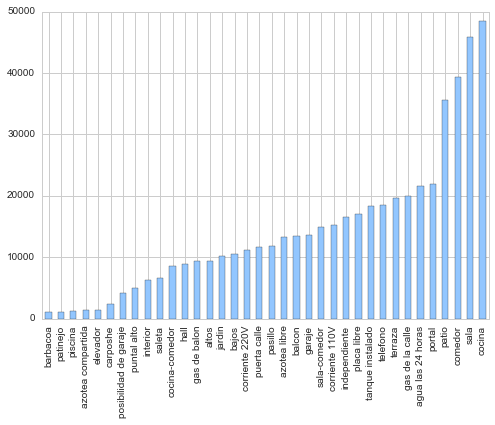

In [12]:
listing_amenities.sum(axis=0).sort_values().plot(kind='bar')

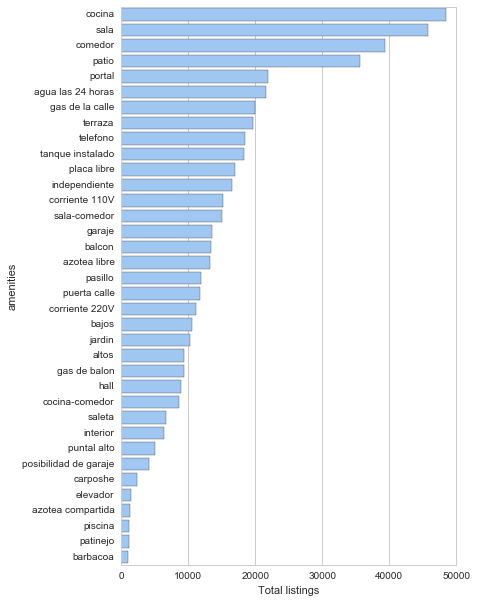

In [13]:
num_listings_by_amenity = listing_amenities.sum(axis=0).sort_values(ascending=False).reset_index().rename(columns={0: 'counts', 'index': 'amenities'})

f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(x='counts', y='amenities', data=num_listings_by_amenity, color='b')
plt.xlabel('Total listings')

Kitchen, living room, dining room, and patio lead the pack. Listings with only 1-4 amenities likely have only have these, and those with 5+ amenities likely have this and more.

(@TODO: What combinations are the most prevalent?)

Next you have terraces and services: water, gas, telephone, septic tank. 

Near to bottom, rarer amenities like barbeque pits, pools, elevadors and so on.

This distribution looks reasonable, further increasing our confidence in the amenities data.



## Near to

In [14]:
listings.near_to.value_counts()

Coopelia                             54
23 y 12                              49
41 y 42                              46
23 y Paseo                           40
Linea y Paseo                        40
23 y G                               37
santa catalina y 10 de octubre       36
23 y 26                              36
5ta y 42                             36
acosta y 10 de octubre               36
Boyeros y Tulipan                    35
Infanta y San Lazaro                 34
31 y 30                              34
lacret y mayia                       33
porvenir y calle B                   33
10 de octubre y calzada de luyano    31
19 y 70                              28
Universidad de la Habana             28
Santa Fe                             26
Zoológico de 26                      26
Cine Acapulco                        26
Linea y G                            25
Reina y Belascoain                   24
100 y 51                             22
Tunel de linea                       21


The tiny percentage of listings with near to values seem to have pretty consistently structured data, and a long trail of placenames.

Perhaps the most frequently mentioned nearby places are highly desirable, so this could be predictive of higher asking prices?

## Construction Era

In [15]:
listings.construction_era.value_counts()

Capitalista década del 50    1362
Capitalista década del 40     367
Década de los 2000            345
Década de los 80              302
Década de los 90              292
Década del 60                 193
Antes de 1940                 170
Luego del 2010                160
Década de los 70              150
Name: construction_era, dtype: int64

Of the few listings that have feature construction eras, most are either from right before the Revolution, or from the past couple of decades.

## Meters Squared

In [16]:
listings.meters_squared.describe()

count        9635.000000
mean        22494.695589
std       1161009.491064
min             1.000000
25%            72.000000
50%           120.000000
75%           240.000000
max      90000000.000000
Name: meters_squared, dtype: float64

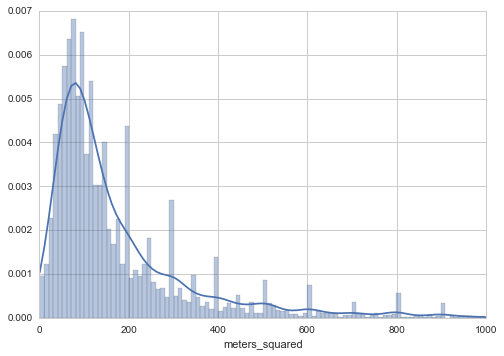

In [20]:
# @TODO: fix this bug
listings_meters_not_null = listings.meters_squared[~listings.meters_squared.isnull()]
sns.distplot(listings_meters_not_null[listings_meters_not_null < 1000], bins=100)

## Mobile number and contact number

In [18]:
phone_number_counts = listings.phone_number.value_counts()
phone_number_counts

2034874                        161
8820963                        137
047-66972                       94
8795870                         90
6433093                         86
8330582                         80
6409761                         70
7641873                         68
2038375                         67
047-66972.                      66
52901442                        64
2658015                         62
2033256                         57
2022414                         55
8792233                         55
52990828                        52
205-4015                        50
8783302                         44
7643637                         44
8338158                         43
6414194                         42
8610358                         41
2074054*52957981                39
8330582, 58082727               39
643-1774 o 644-2073             38
698 56 09 y 5363 66 60          38
644-2073                        36
8730679                         35
8368820, 53226999   

In [19]:
phone_number_counts.shape[0]

31618

There are 31,618 unique phone numbers among the 48.5K of listings with numbers. Many phone numbers are poorly formatted.

(0, 20)

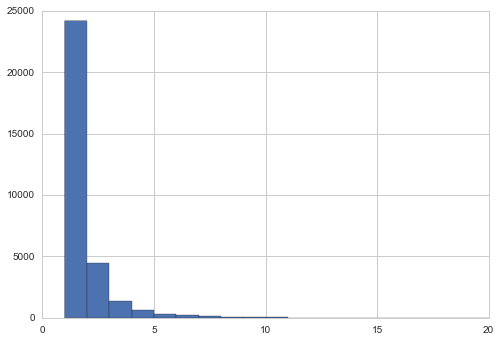

In [20]:
phone_number_counts.hist(bins=160)
plt.xlim((0, 20))

In [21]:
num_unique_phone_numbers = phone_number_counts.shape[0]
num_numbers_two_plus_listings = phone_number_counts[phone_number_counts > 1].shape[0]
num_numbers_two_plus_listings / num_unique_phone_numbers * 100

23.48978430008223

In [22]:
num_numbers_three_plus_listings = phone_number_counts[phone_number_counts > 2].shape[0]
num_numbers_three_plus_listings / num_unique_phone_numbers * 100

9.273198810803972

23% of phone numbers appear in two listings or more.
9% of numbers appear in three listings or more. These might indicates listings posted by brokers, or that the listing is repeated.

@TODO: What's the right way of thinking about / analyzing this?

## Contact name

In [23]:
contact_name_counts = listings.contact_name.value_counts()
contact_name_counts

sergio                                                                364
carlos                                                                256
jorge                                                                 252
lazaro                                                                195
alejandro                                                             194
ernesto                                                               184
mercedes                                                              162
maria                                                                 160
juan manuel                                                           158
lourdes                                                               154
luis                                                                  148
ana                                                                   130
roberto                                                               126
mayra                                 

In [24]:
num_unique_contact_names = contact_name_counts.shape[0]
num_unique_contact_names

20700

There are 20K unique contact names among the 54.7K listings with contact names. However, most contact names are only first name, so there are lots of duplicates.


## Number of sellers on site
To figure out the number of unique people putting up listings on the site, we'd have the clean up the numbers and names and count the number of unique combinations.

Here's a rough estimate:

In [25]:
num_listers = (listings.phone_number + listings.contact_name).nunique()
num_listers

34825

In [26]:
listings_with_phone_numbers = ~listings.phone_number.isnull()
listings_with_contact_names = ~listings.contact_name.isnull()
num_identified_listings = (listings_with_phone_numbers | listings_with_contact_names).sum()
num_identified_listings

58052

In [27]:
num_identified_listings / num_listers

1.6669633883704236

There are roughly 34K unique listers littered among the 58K listings with either a phone number or name listed. There are roughly 1.6 posts per lister.

## Notes

In [35]:
listings.notes.head(4)

0                                                    -
1    se compra terreno en cualquier parte de la habana
2                                                  NaN
3               COMPRO BOVEDA EN ELCEMENTERIO DE COLON
Name: notes, dtype: object

Due to the way the scraper is written, a good number of note value only contain the "-" character. 

@TODO: rewrite scraper to output None instead of -.

In [38]:
num_blank_notes = listings[listings.notes == '-'].shape[0]
pct_blank_notes = num_blank_notes / num_listings * 100
true_pct_blank_not_null = pct_not_null.notes - pct_blank_notes
true_pct_blank_not_null


92.618574135258285

Once we account for these blank descriptions, 92% of listings still have note fields.

(0, 200)

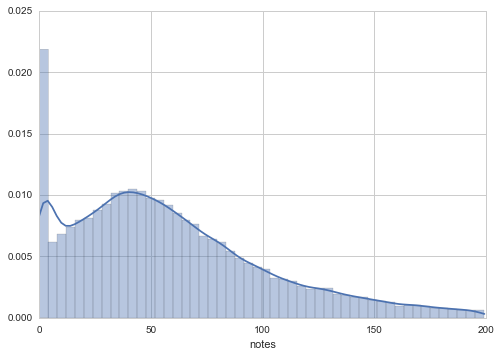

In [79]:
words_per_note = listings.notes_str.apply(lambda s: len(s.split()))
sns.distplot(words_per_note[words_per_note < 200])
plt.xlim((0,200))

In [80]:
words_per_note.describe()

count    63863.000000
mean        73.370293
std        193.317542
min          0.000000
25%         27.000000
50%         53.000000
75%         89.000000
max      10034.000000
Name: notes, dtype: float64

The median number of words per note is 53, with a large amount of variation. There might be good stuff to mine here.

In [ ]:
# Other info

In [101]:
# Only have to do this because otherwise NaN coerce to 'nan'..
listings_other_info_not_null = listings.other_info[~listings.other_info.isnull()]
words_per_other_info = listings_other_info_not_null.apply(lambda s: len(s.split()))


In [107]:
words_per_other_info.value_counts()

3     3444
2     1102
0      846
6      658
5      625
4      597
7      525
8      514
1      457
10     435
9      415
11     346
12     345
13     294
14     251
15     206
16     197
17     156
19     146
18     128
20     125
21     113
22     103
24      97
23      79
28      72
26      70
25      68
27      59
31      57
30      48
29      42
32      42
34      39
33      38
35      38
37      29
36      25
38      25
39      19
40      17
41      13
42      11
44      11
43      10
49       6
48       4
45       4
50       2
51       1
46       1
47       1
Name: other_info, dtype: int64

(0, 25)

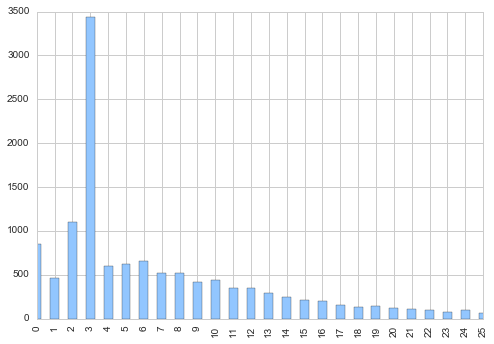

In [112]:
words_per_other_info.value_counts().sort_index().plot(kind='bar')
plt.xlim((0, 25))
# TODO: HOW TO MAKE THESE WILL?
# sns.distplot(words_per_listing[words_per_listing < 10], bins=10)

In [113]:
words_per_other_info.describe()

count    12956.000000
mean         7.937249
std          8.174326
min          0.000000
25%          3.000000
50%          5.000000
75%         11.000000
max         51.000000
Name: other_info, dtype: float64

There's a lot less information in this field..

## Location

In [127]:
locations_not_null = listings.location[~listings.location.isnull()]
locations_not_null.apply(lambda s: len(s.split('en '))).value_counts()


2    63103
3      297
4        1
Name: location, dtype: int64

If you split the locations on "en ", the vast majority of fields only get two values out of that.
Some of the first values are empty, some are streets:

In [142]:
num_first_not_empty = locations_not_null.apply(lambda s: s.split('en ')[0]).value_counts().shape[0]
num_first_not_empty

16933

In [143]:
num_first_not_empty / (63103 + 297 + 1)

0.2670778063437485

About 26% of them are not empty. In other words, 26% of the records have streets.

@TODO: Parse the strings, measure these things precisely.

In [135]:
locations_not_null.apply(lambda s: len(s.split('en ')[-1].split(', '))).value_counts()

3    34424
2    28977
Name: location, dtype: int64

Of all the location strings after the last 'en', some have 3 locations while others have two.
For those that have three, perhaps we just need the last two? Or we concatenate the first two?

Overall, we have

(streets optional), (nabe 1 optional), (nabe 2), (city)

## Asking price

In [21]:
listings_with_price = listings.price[~listings.price.isnull()]
clean_listing_prices = listings_with_price.apply(lambda s: float(s.replace(',', '')))

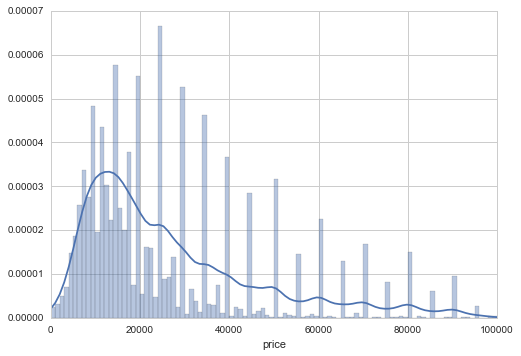

In [22]:
plt.figure()
sns.distplot(clean_listing_prices[clean_listing_prices < 100000], bins=100)

In [23]:
clean_listing_prices.quantile(np.arange(0,1.1,.1))
# Use this to manually make buckets.

# ordered logit if you bucket
# if you run regression keep it as a continous variable.

0.0             1
0.1          8000
0.2         12000
0.3         15000
0.4         18000
0.5         23000
0.6         29000
0.7         35000
0.8         50000
0.9         80000
1.0    1111111111
Name: price, dtype: float64

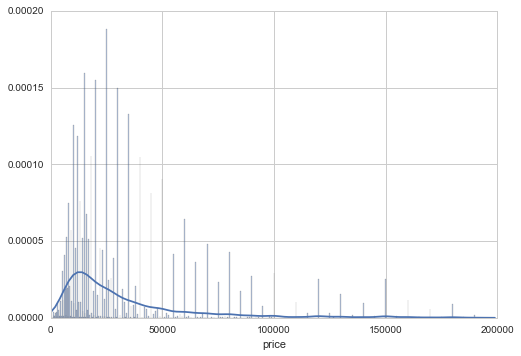

In [162]:
plt.figure()
sns.distplot(clean_listing_prices[clean_listing_prices < 200000], bins=600)

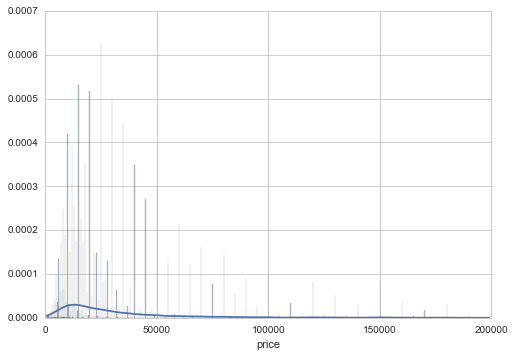

In [163]:
plt.figure()
sns.distplot(clean_listing_prices[clean_listing_prices < 200000], bins=2000)

@TODO: FIX THIS!